In [11]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import datetime
import itertools

# Later, for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklearn below, this keeps them 
# out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
def update_calendar(cutoff):
    calendar_update = calendar.iloc[:cutoff, :]
    calendar_dates = calendar_update[['date', 'd']]
    calendar_dates = calendar_dates.set_index('d')
    return calendar_dates

def drop_christmas(series):
    df = calendar[['date', 'd']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['month'] = df.index.month
    df['day'] = df.index.day
    month_mask = df['month'] == 12
    day_mask = df['day'] == 25
    df = df[month_mask & day_mask]
    df = df.drop(columns = ['month', 'day'])
    df['date'] = df.index
    df = df.set_index('d')
    lst = df.index.tolist()
    return series.drop(index = lst)

def make_date_time(Series):
    df = pd.DataFrame(Series)
    df1 = df.join(calendar_updates)
    df1['date'] = pd.to_datetime(df1['date'])
    df1 = df1.set_index('date')
    return df1

#To make a graph with a linear trendline
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(name)
    
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)
    
# To make a detrended graph
def detrended_graph(Series):
    python_series = Series
    python_linear_trend = fit_linear_trend(python_series)
    python_series_detrended = python_series - python_linear_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(python_series_detrended.index, python_series_detrended)
    ax.set_title("Sales Detrended")
    plt.tight_layout()
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)
    
def create_monthly_dummies(series):
    i = series.index.interval
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(i).iloc[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series, interval='month'):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

def deseasonalize(Series):
    series = Series.iloc[:, 0]
    seasonal_trend = fit_seasonal_trend(Series)
    seasonal_detrended = series - seasonal_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(Series.index, _seasonal_detrended)
    ax.set_title(f'Walmart {list(Series)[0]} Sales, Deseasonalized')
    
def resample_series(series, interval):
    df = series.resample(interval).sum()
    df = df.iloc[1:, :]
    df = df.iloc[:-1, :]
    return df

def plot_seasonal_decomposition(axs, series):
    sd = sm.tsa.seasonal_decompose(series)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[0].set_ylabel('Sales')
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[1].set_ylabel('Sales')
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[2].set_ylabel('Sales')
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Sales')
    
def make_forecast(series, interval, num_of_test_periods, forecast_period, forecast_month):
    '''
    Forecast Sales at Given Interval for a Given Series. Can be used to train, or to predict unseen data.
    
    Params:
    Series- Series that you want to forecast
    Interval- 'Q, M, W, d'
    num_of_test_periods- For example, if you enter '2' it will take your 'monthly' forecast
                         and will leave off the latest 2 periods so you can test against it for accuracy
    forecast_period- Can be up to the num_of_test_periods. If you leave off 2 months, you can forecast/predict
                     the first or the second month
    forecast_month-  If your forecast period is 1 and you are forecasting into february, you need to put a 2
                     so the seasonality for that month can be added in
    
    Returns:
    forecast- The projected units sold for that specific series
    error- will give you the error for what percent your forecast differs from actuals
    '''
    df = resample_series(series, interval)
    train_series = df[:-num_of_test_periods]
    X = make_design_matrix(np.arange(len(train_series)) + 1)
    linear_trend_ols = sm.OLS(train_series.values, X).fit()
    slope_intercept = linear_trend_ols.params
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    trend = slope*(len(train_series) + forecast_period) + intercept
    sd = sm.tsa.seasonal_decompose(df)
    seasonal_pattern = sd.seasonal[11:23]
    seasonal = seasonal_pattern.loc[seasonal_pattern.index.month == forecast_month].iloc[0, 0]
    forecast = trend + seasonal
    actual = df[-num_of_test_periods:].loc[df[-num_of_test_periods:].index.month == forecast_month].iloc[0, 0]
    error = (forecast-actual)/actual
    return forecast, error, actual

def trickle_down_forecast(upper_forecast, actual, path_lst):
    forecast = upper_forecast * np.prod(path_lst)
    if actual == None:
        return forecast
    else:
        error = (forecast - actual)/actual
        return forecast, error
    
def naive_monthly_distribution(store, department, product_id, lst_of_years, month_num):
    lst=[]
    newDF = pd.DataFrame()
    mask1 = sales_train['store_id'] == store
    mask2 = sales_train['dept_id'] == department
    df = sales_train[mask1 & mask2].copy()
    df = df.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    df = df.set_index('id')
    df = df.loc[[product_id]]
    df = df.T
    df = make_date_time(df)
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df = df[df['month'] == month_num]
    for year in lst_of_years:
        df1 = df.copy()
        df1 = df1[df1['year'] == year]
        df1.loc['TOTAL']= df1.iloc[:, 0].sum()
        df1[f'{list(df1)[0]}_percent'] = df[list(df1)[0]] / df1.iloc[-1:, 0][0]
        lst.append(pd.DataFrame(list(df1[list(df1)].iloc[:, -1][:-1])))
    newDF = pd.concat(lst, ignore_index=True, axis=1)
    newDF['average'] = newDF.mean(numeric_only=True, axis=1)
    newDF.loc['TOTAL']= newDF.sum()
    if month_num == 2:
        check = newDF.iloc[-1, -1] - 1
        if check > 0:
            newDF.iloc[-2, -1] = newDF.iloc[-2, -1] - check
            newDF.iloc[-1, -1] = newDF.iloc[-1, -1] - check
    return newDF

class graphs():
    
    def __init__(self, series, interval, name):
        self.series = series
        self.interval = interval
        self.name = name

    def TSR(self):
        fig, axs = plt.subplots(4, figsize=(14, 8))
        plot_seasonal_decomposition(axs, resample_series(self.series, self.interval))
        fig.suptitle(self.name, y=1.05, x=.525, fontsize = 20)
        plt.tight_layout()
        
    def linear_trend(self):
        fig, ax = plt.subplots(1, figsize=(14, 12))
        plot_linear_trend(ax, self.name, resample_series(self.series, self.interval))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')
        plt.tight_layout()
        
def make_series(store_id, dept_id):
    '''
    Use this function to make a series of the total sales for a specific store and department.
    The series is to be used for forecasting in the make_forecast function.
    '''
    mask1 = sales_train['store_id'] == store_id
    mask2 = sales_train['dept_id'] == dept_id
    series = sales_train[mask1 & mask2].copy()
    series = series.drop(columns = ['id', 'item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    series.loc['TOTAL']= series.sum()
    series = series.T
    series = drop_christmas(series)
    series = make_date_time(series)
    series = series['TOTAL'].to_frame()
    return series

def monthly_product_distribution(store_id, dept_id):
    mask1 = sales_train['store_id'] == store_id
    mask2 = sales_train['dept_id'] == dept_id
    series = sales_train[mask1 & mask2].copy()
    series = series.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    series = series.set_index('id')
    #series = series.loc[[product_id]]
    series = series.T
    series = make_date_time(series)
    series = resample_series(series, 'M')
    series = series.iloc[47:-3, :]
    series.loc['TOTAL']= series.sum()
    series = series.T
    series['jan_percent'] = series.iloc[:, 0] / series.iloc[:, 12]
    series['feb_percent'] = series.iloc[:, 1] / series.iloc[:, 12]
    series['mar_percent'] = series.iloc[:, 2] / series.iloc[:, 12]
    series['april_percent'] = series.iloc[:, 3] / series.iloc[:, 12]
    series['may_percent'] = series.iloc[:, 4] / series.iloc[:, 12]
    series['june_percent'] = series.iloc[:, 5] / series.iloc[:, 12]
    series['july_percent'] = series.iloc[:, 6] / series.iloc[:, 12]
    series['aug_percent'] = series.iloc[:, 7] / series.iloc[:, 12]
    series['sep_percent'] = series.iloc[:, 8] / series.iloc[:, 12]
    series['oct_percent'] = series.iloc[:, 9] / series.iloc[:, 12]
    series['nov_percent'] = series.iloc[:, 10] / series.iloc[:, 12]
    series['dec_percent'] = series.iloc[:, 11] / series.iloc[:, 12]
    total = series.iloc[:, 12].to_frame()
    total_sum = total.sum()[0]
    total['unit_percent'] = total['TOTAL']/total_sum
    return total

def daily_distribution(store_dept_forecast, daily_series, store_id, dept_id, product_id, year, month):
    df = daily_series.iloc[:-1, -1].to_frame()
    df = df.fillna(0)
    df['year'] = year
    df['month'] = month
    if month == 2:
        if year %4 ==0:
            df['day'] = list(range(1,30))
        else:
            df = df.iloc[:-1, :]
            df['day'] = list(range(1,29))
    elif month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12:
        df['day'] = range(1,32)
    else:
        df['day'] = range(1, 31)
    df['date'] = pd.to_datetime(df[["year", "month", "day"]])
    df.index = df['date']
    df = df.drop(columns = ['year', 'month', 'day', 'date'])
    total = monthly_product_distribution(store_id, dept_id)
    item_distribution = total.loc[product_id][1]
    forecast_month_item = store_dept_forecast*item_distribution
    df['units_sold'] = df['average'] * forecast_month_item
    print(forecast_month_item)
    return df.round(2)

def get_product_actuals(store_id, dept_id, product_id, month, year):
    mask11 = sales_train['store_id'] == store_id
    mask21 = sales_train['dept_id'] == dept_id
    series1 = sales_train[mask11 & mask21].copy()
    series1 = series1.drop(columns = ['item_id', 'dept_id', 'store_id', 'state_id', 'cat_id'])
    series1 = series1.T
    series1 = drop_christmas(series1)
    series1 = make_date_time(series1)
    series1 = series1.T
    series1 = series1.set_index('NaT')
    series1 = series1.loc[product_id].to_frame()
    series1 = series1[series1.index.month == month]
    series1 = series1[series1.index.year == year]
    return series1

def actual_vs_forecast(actual_series, forecast_series):
    df = forecast_series.copy()
    df['actual'] = actual_series[list(actual_series)[0]]
    df['forecast'] = abs(df['forecast'].round(1))
    return df

def reg_round_comparison(df):
    df2 = df.round().copy()
    df2['year'] = df2.index.year
    df2['month'] = df2.index.month
    df2['day'] =  df2.index.day
    df2['date'] = pd.to_datetime(df2[["year", "month", "day"]])
    x = df2['date'].to_numpy().astype('datetime64[D]')
    y = x.tolist()
    y.append('Total')
    y = np.asarray(y)
    df2.loc['TOTAL']= df2.sum()
    df2['forecast'] = df2['forecast'].apply(np.int64)
    df2 = df2.set_index(y)
    df2 = df2.drop(columns = ['year', 'month', 'day', 'date'])
    return df2

def manual_rounding_compy(df, round_up_decimal):
    df3 = df.copy()
    for i in range(len(df3)):
        if int(str(df3['forecast'][i])[-1:]) >= round_up_decimal:
            df3['forecast'][i] = np.ceil(df3['forecast'][i])
        else:
            df3['forecast'][i] = np.floor(df3['forecast'][i])
    df3['year'] = df3.index.year
    df3['month'] = df3.index.month
    df3['day'] =  df3.index.day
    df3['date'] = pd.to_datetime(df3[["year", "month", "day"]])
    x = df3['date'].to_numpy().astype('datetime64[D]')
    y = x.tolist()
    y.append('Total')
    y = np.asarray(y)
    df3.loc['Total']= df3.sum()
    df3['forecast'] = df3['forecast'].apply(np.int64)
    df3 = df3.set_index(y)
    df3 = df3.drop(columns = ['year', 'month', 'day', 'date'])
    return df3

def no_rounding_comparison(df):
    df2 = df.copy()
    df2['year'] = df2.index.year
    df2['month'] = df2.index.month
    df2['day'] =  df2.index.day
    df2['date'] = pd.to_datetime(df2[["year", "month", "day"]])
    x = df2['date'].to_numpy().astype('datetime64[D]')
    y = x.tolist()
    y.append('Total')
    y = np.asarray(y)
    df2.loc['TOTAL']= df2.sum()
    df2 = df2.set_index(y)
    df2 = df2.drop(columns = ['year', 'month', 'day', 'date'])
    return df2

#New as of 5/17/20
def series_setup(store_id, dept_id):
    lst = []
    for i in store_id:
        count = 0
        while count != len(dept_id):
            lst.append([i, dept_id[count]])
            count += 1
    return lst

In [3]:
sales_train = pd.read_csv('../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
calendar = pd.read_csv('../data/calendar.csv')

calendar_updates = update_calendar(1913)

sales_train_cat = sales_train.groupby(['cat_id']).sum()
sales_train_cat_food = sales_train_cat.iloc[0, :].T
sales_train_cat_hobbies = sales_train_cat.iloc[1, :].T
sales_train_cat_household = sales_train_cat.iloc[2, :].T

sales_train_cat.loc['TOTAL']= sales_train_cat.sum()
sales_train_cat_all = sales_train_cat.iloc[3, :].T

sales_train_dept = sales_train.groupby(['dept_id']).sum()
sales_train_dept_food1 = sales_train_dept.iloc[0, :].T
sales_train_dept_food2 = sales_train_dept.iloc[1, :].T
sales_train_dept_food3 = sales_train_dept.iloc[2, :].T
sales_train_dept_hobbies1 = sales_train_dept.iloc[3, :].T
sales_train_dept_hobbies2 = sales_train_dept.iloc[4, :].T
sales_train_dept_household1 = sales_train_dept.iloc[5, :].T
sales_train_dept_household2 = sales_train_dept.iloc[6, :].T

sales_train_state = sales_train.groupby(['state_id']).sum()
sales_train_ca = sales_train_state.iloc[0, :].T
sales_train_tx = sales_train_state.iloc[1, :].T
sales_train_wi = sales_train_state.iloc[2, :].T

sales_train_store = sales_train.groupby(['store_id']).sum()
sales_train_ca1 = sales_train_store.iloc[0, :].T
sales_train_ca2 = sales_train_store.iloc[1, :].T
sales_train_ca3 = sales_train_store.iloc[2, :].T
sales_train_ca4 = sales_train_store.iloc[3, :].T
sales_train_tx1 = sales_train_store.iloc[4, :].T
sales_train_tx2 = sales_train_store.iloc[5, :].T
sales_train_tx3 = sales_train_store.iloc[6, :].T
sales_train_wi1 = sales_train_store.iloc[7, :].T
sales_train_wi2 = sales_train_store.iloc[8, :].T
sales_train_wi3 = sales_train_store.iloc[9, :].T

sales_train_cat_food = drop_christmas(sales_train_cat_food)
sales_train_cat_hobbies = drop_christmas(sales_train_cat_hobbies)
sales_train_cat_household = drop_christmas(sales_train_cat_household)

sales_train_cat_all = drop_christmas(sales_train_cat_all)

sales_train_dept_food1 = drop_christmas(sales_train_dept_food1)
sales_train_dept_food2 = drop_christmas(sales_train_dept_food2)
sales_train_dept_food3 = drop_christmas(sales_train_dept_food3)
sales_train_dept_hobbies1 = drop_christmas(sales_train_dept_hobbies1)
sales_train_dept_hobbies2 = drop_christmas(sales_train_dept_hobbies2)
sales_train_dept_household1 = drop_christmas(sales_train_dept_household1)
sales_train_dept_household2 = drop_christmas(sales_train_dept_household2)

sales_train_ca = drop_christmas(sales_train_ca)
sales_train_tx = drop_christmas(sales_train_tx)
sales_train_wi = drop_christmas(sales_train_wi)

sales_train_ca1 = drop_christmas(sales_train_ca1)
sales_train_ca2 = drop_christmas(sales_train_ca2)
sales_train_ca3 = drop_christmas(sales_train_ca3)
sales_train_ca4 = drop_christmas(sales_train_ca4)
sales_train_tx1 = drop_christmas(sales_train_tx1)
sales_train_tx2 = drop_christmas(sales_train_tx2)
sales_train_tx3 = drop_christmas(sales_train_tx3)
sales_train_wi1 = drop_christmas(sales_train_wi1)
sales_train_wi2 = drop_christmas(sales_train_wi2)
sales_train_wi3 = drop_christmas(sales_train_wi3)

big_food = make_date_time(sales_train_cat_food)
big_hobby = make_date_time(sales_train_cat_hobbies)
big_household = make_date_time(sales_train_cat_household)

big_all = make_date_time(sales_train_cat_all)

med_food1 = make_date_time(sales_train_dept_food1)
med_food2 = make_date_time(sales_train_dept_food2)
med_food3 = make_date_time(sales_train_dept_food3)
med_hobby1 = make_date_time(sales_train_dept_hobbies1)
med_hobby2 = make_date_time(sales_train_dept_hobbies2)
med_household1 = make_date_time(sales_train_dept_household1)
med_household2 = make_date_time(sales_train_dept_household2)

state_ca = make_date_time(sales_train_ca)
state_tx = make_date_time(sales_train_tx)
state_wi = make_date_time(sales_train_wi)

store_ca1 = make_date_time(sales_train_ca1)
store_ca2 = make_date_time(sales_train_ca2)
store_ca3 = make_date_time(sales_train_ca3)
store_ca4 = make_date_time(sales_train_ca4)
store_tx1 = make_date_time(sales_train_tx1)
store_tx2 = make_date_time(sales_train_tx2)
store_tx3 = make_date_time(sales_train_tx3)
store_wi1 = make_date_time(sales_train_wi1)
store_wi2 = make_date_time(sales_train_wi2)
store_wi3 = make_date_time(sales_train_wi3)

series_lst = [big_all, big_food, big_hobby, big_household,
              med_food1, med_food2, med_food3, med_hobby1, med_hobby2, med_household1, med_household2,
              state_ca, state_tx, state_wi,
              store_ca1, store_ca2, store_ca3, store_ca4, store_tx1, store_tx2, store_tx3, store_wi1, store_wi2, store_wi3
             ]

sales_all = sales_train_cat.T
sales_all = drop_christmas(sales_all)
sales_all = make_date_time(sales_all)
sales_all = resample_series(sales_all, 'M')
sales_all['foods_percent'] = sales_all['FOODS']/sales_all['TOTAL']
sales_all['hobbies_percent'] = sales_all['HOBBIES']/sales_all['TOTAL']
sales_all['household_percent'] = sales_all['HOUSEHOLD']/sales_all['TOTAL']

sales_dept_all = sales_train_dept.copy()
sales_dept_all.loc['TOTAL']= sales_dept_all.sum()
sales_dept_all = sales_dept_all.T
sales_dept_all = drop_christmas(sales_dept_all)
sales_dept_all = make_date_time(sales_dept_all)
sales_dept_all = resample_series(sales_dept_all, 'M')
sales_dept_all['foods1_percent'] = sales_dept_all['FOODS_1']/sales_dept_all['TOTAL']
sales_dept_all['foods2_percent'] = sales_dept_all['FOODS_2']/sales_dept_all['TOTAL']
sales_dept_all['foods3_percent'] = sales_dept_all['FOODS_3']/sales_dept_all['TOTAL']
sales_dept_all['hobbies1_percent'] = sales_dept_all['HOBBIES_1']/sales_dept_all['TOTAL']
sales_dept_all['hobbies2_percent'] = sales_dept_all['HOBBIES_2']/sales_dept_all['TOTAL']
sales_dept_all['household1_percent'] = sales_dept_all['HOUSEHOLD_1']/sales_dept_all['TOTAL']
sales_dept_all['household2_percent'] = sales_dept_all['HOUSEHOLD_2']/sales_dept_all['TOTAL']

sales_state_all = sales_train_state.copy()
sales_state_all.loc['TOTAL']= sales_state_all.sum()
sales_state_all = sales_state_all.T
sales_state_all = drop_christmas(sales_state_all)
sales_state_all = make_date_time(sales_state_all)
sales_state_all = resample_series(sales_state_all, 'M')
sales_state_all['ca_percent'] = sales_state_all['CA']/sales_state_all['TOTAL']
sales_state_all['tx_percent'] = sales_state_all['TX']/sales_state_all['TOTAL']
sales_state_all['wi_percent'] = sales_state_all['WI']/sales_state_all['TOTAL']

sales_store_all = sales_train_store.copy()
sales_store_all.loc['TOTAL']= sales_store_all.sum()
sales_store_all = sales_store_all.T
sales_store_all = drop_christmas(sales_store_all)
sales_store_all = make_date_time(sales_store_all)
sales_store_all = resample_series(sales_store_all, 'M')
sales_store_all['ca1_percent'] = sales_store_all['CA_1']/sales_store_all['TOTAL']
sales_store_all['ca2_percent'] = sales_store_all['CA_2']/sales_store_all['TOTAL']
sales_store_all['ca3_percent'] = sales_store_all['CA_3']/sales_store_all['TOTAL']
sales_store_all['ca4_percent'] = sales_store_all['CA_4']/sales_store_all['TOTAL']
sales_store_all['tx1_percent'] = sales_store_all['TX_1']/sales_store_all['TOTAL']
sales_store_all['tx2_percent'] = sales_store_all['TX_2']/sales_store_all['TOTAL']
sales_store_all['tx3_percent'] = sales_store_all['TX_3']/sales_store_all['TOTAL']
sales_store_all['wi1_percent'] = sales_store_all['WI_1']/sales_store_all['TOTAL']
sales_store_all['wi2_percent'] = sales_store_all['WI_2']/sales_store_all['TOTAL']
sales_store_all['wi3_percent'] = sales_store_all['WI_3']/sales_store_all['TOTAL']

sales_dept_food = sales_train_dept.iloc[:3, :].copy()
sales_dept_food.loc['TOTAL']= sales_dept_food.sum()
sales_dept_food = sales_dept_food.T
sales_dept_food = drop_christmas(sales_dept_food)
sales_dept_food = make_date_time(sales_dept_food)
sales_dept_food = resample_series(sales_dept_food, 'M')
sales_dept_food['foods1_percent'] = sales_dept_food['FOODS_1']/sales_dept_food['TOTAL']
sales_dept_food['foods2_percent'] = sales_dept_food['FOODS_2']/sales_dept_food['TOTAL']
sales_dept_food['foods3_percent'] = sales_dept_food['FOODS_3']/sales_dept_food['TOTAL']

sales_dept_hobby = sales_train_dept.iloc[3:5, :].copy()
sales_dept_hobby.loc['TOTAL']= sales_dept_hobby.sum()
sales_dept_hobby = sales_dept_hobby.T
sales_dept_hobby = drop_christmas(sales_dept_hobby)
sales_dept_hobby = make_date_time(sales_dept_hobby)
sales_dept_hobby = resample_series(sales_dept_hobby, 'M')
sales_dept_hobby['hobbies1_percent'] = sales_dept_hobby['HOBBIES_1']/sales_dept_hobby['TOTAL']
sales_dept_hobby['hobbies2_percent'] = sales_dept_hobby['HOBBIES_2']/sales_dept_hobby['TOTAL']

sales_dept_household = sales_train_dept.iloc[5:7, :].copy()
sales_dept_household.loc['TOTAL']= sales_dept_household.sum()
sales_dept_household = sales_dept_household.T
sales_dept_household = drop_christmas(sales_dept_household)
sales_dept_household = make_date_time(sales_dept_household)
sales_dept_household = resample_series(sales_dept_household, 'M')
sales_dept_household['household1_percent'] = sales_dept_household['HOUSEHOLD_1']/sales_dept_household['TOTAL']
sales_dept_household['household2_percent'] = sales_dept_household['HOUSEHOLD_2']/sales_dept_household['TOTAL']

sales_store_ca = sales_train_store.iloc[:4, :].copy()
sales_store_ca.loc['TOTAL']= sales_store_ca.sum()
sales_store_ca = sales_store_ca.T
sales_store_ca = drop_christmas(sales_store_ca)
sales_store_ca = make_date_time(sales_store_ca)
sales_store_ca = resample_series(sales_store_ca, 'M')
sales_store_ca['ca1_percent'] = sales_store_ca['CA_1']/sales_store_ca['TOTAL']
sales_store_ca['ca2_percent'] = sales_store_ca['CA_2']/sales_store_ca['TOTAL']
sales_store_ca['ca3_percent'] = sales_store_ca['CA_3']/sales_store_ca['TOTAL']
sales_store_ca['ca4_percent'] = sales_store_ca['CA_4']/sales_store_ca['TOTAL']


sales_store_tx = sales_train_store.iloc[4:7, :].copy()
sales_store_tx.loc['TOTAL']= sales_store_tx.sum()
sales_store_tx = sales_store_tx.T
sales_store_tx = drop_christmas(sales_store_tx)
sales_store_tx = make_date_time(sales_store_tx)
sales_store_tx = resample_series(sales_store_tx, 'M')
sales_store_tx['tx1_percent'] = sales_store_tx['TX_1']/sales_store_tx['TOTAL']
sales_store_tx['tx2_percent'] = sales_store_tx['TX_2']/sales_store_tx['TOTAL']
sales_store_tx['tx3_percent'] = sales_store_tx['TX_3']/sales_store_tx['TOTAL']

sales_store_wi = sales_train_store.iloc[7:10, :].copy()
sales_store_wi.loc['TOTAL']= sales_store_wi.sum()
sales_store_wi = sales_store_wi.T
sales_store_wi = drop_christmas(sales_store_wi)
sales_store_wi = make_date_time(sales_store_wi)
sales_store_wi = resample_series(sales_store_wi, 'M')
sales_store_wi['wi1_percent'] = sales_store_wi['WI_1']/sales_store_wi['TOTAL']
sales_store_wi['wi2_percent'] = sales_store_wi['WI_2']/sales_store_wi['TOTAL']
sales_store_wi['wi3_percent'] = sales_store_wi['WI_3']/sales_store_wi['TOTAL']

foods_mean = sales_all.iloc[:, 4].mean()
hobby_mean = sales_all.iloc[:, 5].mean()
household_mean =sales_all.iloc[:, 6].mean()
ca_mean = sales_state_all.iloc[:, 4].mean()
tx_mean = sales_state_all.iloc[:, 5].mean()
wi_mean = sales_state_all.iloc[:, 6].mean()
foods1_mean = sales_dept_food.iloc[:, 4].mean()
foods2_mean = sales_dept_food.iloc[:, 5].mean()
foods3_mean = sales_dept_food.iloc[:, 6].mean()
hobby1_mean = sales_dept_hobby.iloc[:, 3].mean()
hobby2_mean = sales_dept_hobby.iloc[:, 4].mean()
household1_mean = sales_dept_household.iloc[16:, 3].mean()
household2_mean = sales_dept_household.iloc[16:, 4].mean()
ca1_mean = sales_store_ca.iloc[:, 5].mean()
ca2_mean = sales_store_ca.iloc[:, 6].mean()
ca3_mean = sales_store_ca.iloc[:, 7].mean()
ca4_mean = sales_store_ca.iloc[:, 8].mean()
tx1_mean = sales_store_tx.iloc[40:, 4].mean()
tx2_mean = sales_store_tx.iloc[40:, 5].mean()
tx3_mean = sales_store_tx.iloc[40:, 6].mean()
wi1_mean = sales_store_wi.iloc[22:, 4].mean()
wi2_mean = sales_store_wi.iloc[22:, 5].mean()
wi3_mean = sales_store_wi.iloc[22:, 6].mean()

#New...as of 5/17/20
dept_id = sales_train.dept_id.unique()
cat_id = sales_train.cat_id.unique()
store_id = sales_train.store_id.unique()
state_id = sales_train.state_id.unique()

In [35]:
series_lst = []
for i in series_setup(store_id, dept_id):
    series_lst.append(make_series(i[0], i[1]))
    
forecast_lst = []
for i in series_lst:
    forecast_lst.append(abs(make_forecast(i, 'M', 2, 1, 2)[1]))
    
arr = np.array(forecast_lst)
arr.mean()

0.10171810390038058

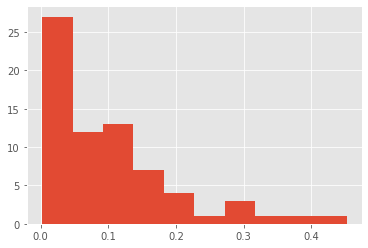

In [36]:
fig, ax = plt.subplots()
ax.hist(arr)
plt.show()

In [68]:
count = 0
for idx, val in enumerate(series_setup(store_id, dept_id)):
    print(f'{count}: {val} error: {round(forecast_lst[idx], 3)}')
    count += 1

0: ['CA_1', 'HOBBIES_1'] error: 0.032
1: ['CA_1', 'HOBBIES_2'] error: 0.159
2: ['CA_1', 'HOUSEHOLD_1'] error: 0.034
3: ['CA_1', 'HOUSEHOLD_2'] error: 0.019
4: ['CA_1', 'FOODS_1'] error: 0.181
5: ['CA_1', 'FOODS_2'] error: 0.003
6: ['CA_1', 'FOODS_3'] error: 0.023
7: ['CA_2', 'HOBBIES_1'] error: 0.114
8: ['CA_2', 'HOBBIES_2'] error: 0.187
9: ['CA_2', 'HOUSEHOLD_1'] error: 0.089
10: ['CA_2', 'HOUSEHOLD_2'] error: 0.087
11: ['CA_2', 'FOODS_1'] error: 0.101
12: ['CA_2', 'FOODS_2'] error: 0.452
13: ['CA_2', 'FOODS_3'] error: 0.289
14: ['CA_3', 'HOBBIES_1'] error: 0.056
15: ['CA_3', 'HOBBIES_2'] error: 0.343
16: ['CA_3', 'HOUSEHOLD_1'] error: 0.101
17: ['CA_3', 'HOUSEHOLD_2'] error: 0.019
18: ['CA_3', 'FOODS_1'] error: 0.05
19: ['CA_3', 'FOODS_2'] error: 0.079
20: ['CA_3', 'FOODS_3'] error: 0.003
21: ['CA_4', 'HOBBIES_1'] error: 0.083
22: ['CA_4', 'HOBBIES_2'] error: 0.087
23: ['CA_4', 'HOUSEHOLD_1'] error: 0.009
24: ['CA_4', 'HOUSEHOLD_2'] error: 0.003
25: ['CA_4', 'FOODS_1'] error: 0.148
2

CA1 store mean is 0.06459742520565472


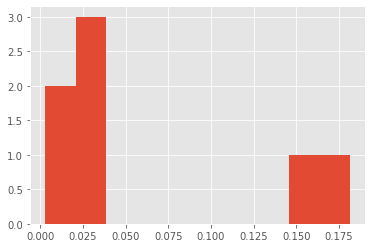

In [66]:
print(f'CA1 store mean is {arr[:7].mean()}')

fig, ax = plt.subplots()
ax.hist(arr[:7])
plt.show()

In [134]:
def store_error_hist(arr, name):
    print(f'{name} store mean forecasting error is {round(arr.mean(),2)}')

    fig, ax = plt.subplots()
    ax.hist(arr)
    ax.set_title(f'{name} Store Forecasting Error Histogram')
    plt.show()

CA store mean forecasting error is 0.1


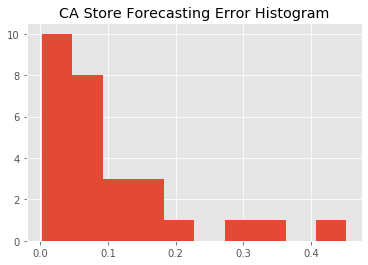

In [135]:
store_error_hist(arr[:28], 'CA')

TX store mean forecasting error is 0.1


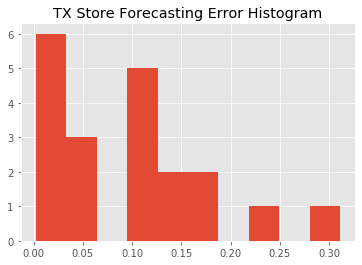

In [136]:
store_error_hist(arr[28:48], 'TX')

WI store mean forecasting error is 0.11


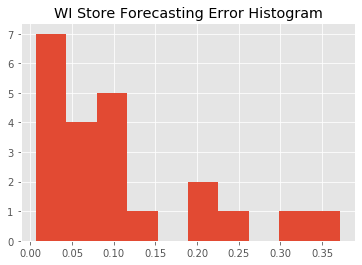

In [137]:
store_error_hist(arr[48:], 'WI')

CA1 store mean forecasting error is 0.06


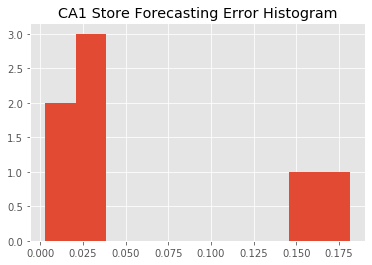

In [138]:
store_error_hist(arr[:7], 'CA1')

CA2 store mean forecasting error is 0.19


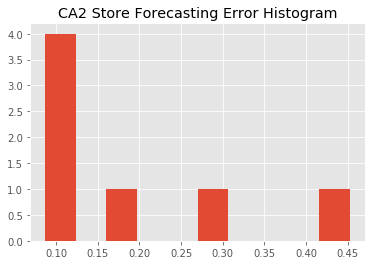

In [139]:
store_error_hist(arr[7:14], 'CA2')

CA3 store mean forecasting error is 0.09


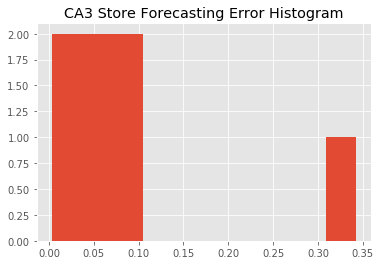

In [140]:
store_error_hist(arr[14:21], 'CA3')

CA4 store mean forecasting error is 0.06


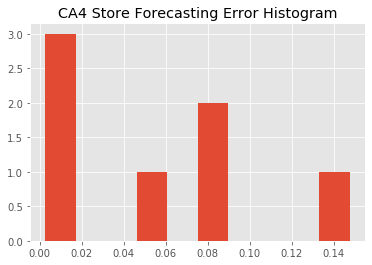

In [141]:
store_error_hist(arr[21:28], 'CA4')

TX1 store mean forecasting error is 0.1


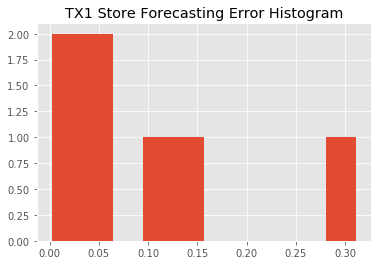

In [142]:
store_error_hist(arr[28:35], 'TX1')

TX2 store mean forecasting error is 0.09


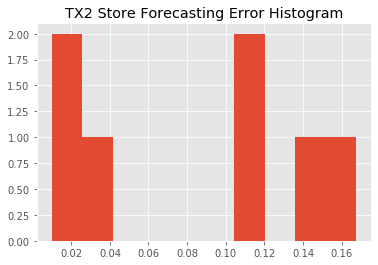

In [143]:
store_error_hist(arr[35:42], 'TX2')

TX3 store mean forecasting error is 0.11


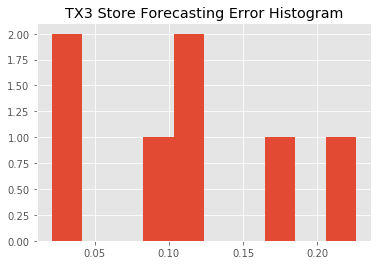

In [144]:
store_error_hist(arr[42:49], 'TX3')

WI1 store mean forecasting error is 0.09


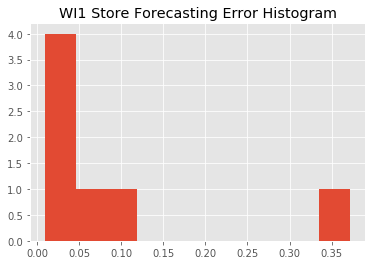

In [145]:
store_error_hist(arr[49:56], 'WI1')

WI2 store mean forecasting error is 0.09


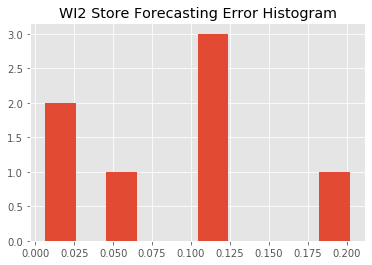

In [146]:
store_error_hist(arr[56:63], 'WI2')

WI3 store mean forecasting error is 0.12


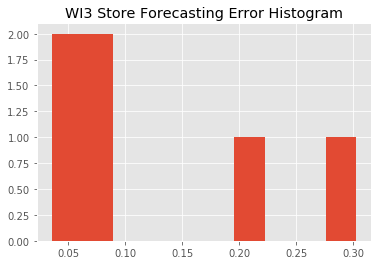

In [147]:
store_error_hist(arr[63:69], 'WI3')